In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
import itertools
import time
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score

In [2]:
train = pd.read_csv('expanded', delimiter='\t', header=None, names=['characteristics'])
train = train['characteristics'].str.split(',', expand=True)
train = train.drop(range(7)).reset_index(drop=True)

In [255]:
# implement descriptive column names
column_names = ['edibility','cap_shape', 'cap_surface', 'cap_color', 'bruises', 
                'odor', 'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color', 
                'stalk_shape', 'stalk_root', 'stalk_surface_above_ring', 'stalk_surface_below_ring', 
                'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type', 'veil_color', 
                'ring_number', 'ring_type', 'spore_print_color', 'population','habitat']
train.columns = column_names
train = train.drop(train[train.isnull().any(axis=1)].index)
train.head()

,edibility,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
837,1,FLAT,FIBROUS,GRAY,NO,1,FREE,CLOSE,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BLACK,SEVERAL,URBAN
7961,1,BELL,FIBROUS,GRAY,NO,1,FREE,CROWDED,BROAD,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,TWO,PENDANT,WHITE,NUMEROUS,GRASSES
2072,1,FLAT,FIBROUS,GRAY,NO,1,FREE,CROWDED,BROAD,CHOCOLATE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,EVANESCENT,BLACK,SCATTERED,GRASSES
4599,0,CONVEX,SCALY,YELLOW,NO,1,FREE,CLOSE,BROAD,GRAY,...,SILKY,BUFF,BROWN,PARTIAL,WHITE,ONE,LARGE,CHOCOLATE,SEVERAL,WOODS
7572,0,KNOBBED,SCALY,RED,NO,1,FREE,CLOSE,NARROW,BUFF,...,SMOOTH,WHITE,PINK,PARTIAL,WHITE,ONE,EVANESCENT,WHITE,SEVERAL,PATHS


In [4]:
# get dummy variables for two-level response
def var_transform (data):
    data['edibility']=data['edibility'].apply(lambda x: 1 if x=='EDIBLE' else 0)
    data['odor']=data['odor'].apply(lambda x: 0 if x=='ALMOND' or x=='ANISE' else 1)
    # put further variable transformation here 
    return data

In [5]:
var_transform(train).head(2)

,edibility,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,1,CONVEX,SMOOTH,WHITE,BRUISES,0,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
1,1,CONVEX,SMOOTH,WHITE,BRUISES,0,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS


In [6]:
#Creating training and test datasets
np.random.seed(2)
splitted_train = train.sample(round(train.shape[0]*0.8))
test = train.drop(splitted_train.index)
train = splitted_train

In [7]:
print(train.shape)
print(test.shape)

(6733, 23)
(1683, 23)


In [38]:
train.gill_size.value_counts()

BROAD     4702
NARROW    2031
Name: gill_size, dtype: int64

In [39]:
train.habitat.value_counts()

WOODS      2520
GRASSES    1944
PATHS       922
LEAVES      681
URBAN       290
MEADOWS     228
WASTE       148
Name: habitat, dtype: int64

In [40]:
train.population.value_counts()

SEVERAL      3247
SOLITARY     1371
SCATTERED    1109
ABUNDANT      411
NUMEROUS      322
CLUSTERED     273
Name: population, dtype: int64

In [41]:
train.cap_shape.value_counts()

CONVEX     3076
FLAT       2605
KNOBBED     670
BELL        354
SUNKEN       25
CONICAL       3
Name: cap_shape, dtype: int64

In [46]:
train.bruises.value_counts()

NO         4048
BRUISES    2685
Name: bruises, dtype: int64

In [128]:
X1 = train[['odor','habitat','gill_size','population','bruises']]
X2 = train[['habitat','gill_size','population','bruises','gill_spacing','cap_surface','cap_color']]
X = train[['habitat','population','gill_size','bruises','gill_spacing','cap_surface''cap_color','ring_number','veil_type','stalk_surface_above_ring','gill_spacing','gill_attachment', data = train).fit()
model.summary()

- Most variables DO NOT work independenly or when adding on top another predictor. We might need futher feature engineering to get the problem solved.

In [290]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.logit(formula = 'edibility~'+ '+'.join(predictor_subset), data = data).fit()
    #calculate accuracy
    pred_values = model.predict(train)
    bins=np.array([0,cutoff,1])
    cm = np.histogram2d(train.edibility, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()

    return {"model":model, "accuracy":accuracy}

In [291]:
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))
    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)
    # Choose the model with the highest RSS
    best_model = models.loc[models['accuracy'].argmax()]
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [292]:
#Function to select the best model amongst the best models for 'k' predictors, where k = 1,2,3,..
models_best = pd.DataFrame(columns=["accuracy", "model"])

tic = time.time()
for i in range(1,1+X.shape[1]):
    models_best.loc[i] = getBest_model(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

         Current function value: 0.626809
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.673789
         Iterations 6


/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NameError: name 'cap_shape_BELL' is not defined
    edibility~cap_shape_BELL
              ^^^^^^^^^^^^^^

# Forward selection

In [136]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    # Choose the model with the highest classification accuracy
    best_model = models.loc[models['accuracy'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [137]:
def forward_selection():
    models_best = pd.DataFrame(columns=["accuracy", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [189]:
#models_best = forward_selection()

# Model Performance

In [13]:
#Function to compute confusion matrix and prediction accuracy
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
    pred_values = model.predict(data)
    bins=np.array([0,cutoff,1])
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])

    print("Classification accuracy = {:.1%}".format(accuracy))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FPR = {:.1%}".format(fpr))


In [96]:
#model=sm.logit(formula='edibility~cap_shape+cap_surface+cap_color+bruises+gill_spacing+gill_size+stalk_color_above_ring',data=train).fit() 
#model.summary()

In [209]:
model2 = sm.logit(formula = 'edibility~habitat+population+gill_size+bruises+gill_spacing+cap_surface+cap_color+ring_number+veil_type+gill_spacing+stalk_surface_above_ring+gill_attachment', data = train).fit()
#model2.summary()

         Current function value: 0.081606
         Iterations: 35


/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [207]:
model3 = sm.logit(formula = 'edibility~population+gill_size+bruises+cap_surface+cap_color+ring_number+stalk_surface_above_ring+gill_spacing+gill_attachment', data = train).fit()
#model3.summary()

         Current function value: 0.088104
         Iterations: 35


/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [252]:
model = sm.logit(formula = 'edibility~habitat+population+gill_size+bruises+gill_spacing+cap_surface+cap_color+ring_number+veil_type+gill_spacing+stalk_surface_above_ring+gill_attachment', data = train).fit()
model.summary()

         Current function value: 0.081606
         Iterations: 35


/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              edibility   No. Observations:                 6733
Model:                          Logit   Df Residuals:                     6700
Method:                           MLE   Df Model:                           32
Date:                Wed, 01 Mar 2023   Pseudo R-squ.:                  0.8818
Time:                        15:34:15   Log-Likelihood:                -549.46
converged:                      False   LL-Null:                       -4648.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             22.3686   3.41e+05   6.56e-05      1.000   -6.69e+05    6.69e+05
habitat[T.LEAVES]                     -0.7751      0.557     -1.391      0.164      -1.867       0.317
habitat[T.MEADOWS]                     0.7879      0.368      2.142      0.032       0.067       1.509
habitat[T.PATHS]                      -1.0382      0.414     -2.507      0.012      -1.850      -0.227
habitat[T.URBAN]                       0.8125      0.301      2.696      0.007       0.222       1.403
habitat[T.WASTE]                      73.2672      1e+05      0.001      0.999   -1.96e+05    1.96e+05
habitat[T.WOODS]                      -0.3493      0.301     -1.161      0.246      -0.939       0.240
population[T.CLUSTERED]              -55.5621   1.01e+05     -0.001      1.000   -1.99e+05    1.99e+05
population[T.NUMEROUS]                 9.7820   2.25e+05   4.35e-05      1.000   -4.41e+05    4.41e+05
population[T.SCATTERED]              -19.5632    1.6e+04     -0.001      0.999   -3.14e+04    3.14e+04
population[T.SEVERAL]                -20.3130    1.6e+04     -0.001      0.999   -3.14e+04    3.14e+04
population[T.SOLITARY]               -17.2896    1.6e+04     -0.001      0.999   -3.14e+04    3.14e+04
gill_size[T.NARROW]                   -6.4452      0.372    -17.309      0.000      -7.175      -5.715
bruises[T.NO]                         -0.2621      0.320     -0.818      0.413      -0.890       0.366
gill_spacing[T.CROWDED]                7.2945      0.419     17.399      0.000       6.473       8.116
cap_surface[T.GROOVES]                 3.9094   6.47e+05   6.05e-06      1.000   -1.27e+06    1.27e+06
cap_surface[T.SCALY]                  -1.3854      0.285     -4.860      0.000      -1.944      -0.827
cap_surface[T.SMOOTH]                 -4.1487      0.331    -12.526      0.000      -4.798      -3.500
cap_color[T.BUFF]                    -24.6596   2805.115     -0.009      0.993   -5522.584    5473.265
cap_color[T.CINNAMON]                 15.2596   1336.529      0.011      0.991   -2604.289    2634.808
cap_color[T.GRAY]                     -1.6991      0.331     -5.140      0.000      -2.347      -1.051
cap_color[T.GREEN]                    11.3852     27.107      0.420      0.674     -41.743      64.514
cap_color[T.PINK]                     -8.3993      0.654    -12.833      0.000      -9.682      -7.117
cap_color[T.PURPLE]                   24.5644   2.13e+04      0.001      0.999   -4.17e+04    4.18e+04
cap_color[T.RED]                      -0.5093      0.406     -1.256      0.209      -1.304       0.286
cap_color[T.WHITE]                    -2.5047      0.363     -6.910      0.000      -3.215      -1.794
cap_color[T.YELLOW]                   -0.7253      0.415     -1.749      0.080      -1.538       0.088
ring_number[T.ONE]                    57.7463   3.26e+05      0.000      1.000   -6.38e+05    6.38e+05
ring_number[T.TWO]                    59.9942   

Classification accuracy = 97.0%
Precision = 97.4%
TPR or Recall = 96.9%
FNR = 3.1%
FPR = 3.0%
ROC-AUC = 99.5%


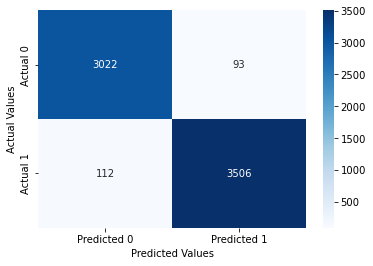

In [253]:
confusion_matrix_data(train,train.edibility,model,0.5)

REMARKS:
- increasing the decision threshold will decrease the number of positives that you predict and increase the number of negatives that you predict.Sci-Kit learn uses a threshold of P>=0.5 by deafult for binary classifications. In many problems a much better result may be obtained by adjusting the threshold, especially for imbalanced classification.

# Threshold Exploration

In [254]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [258]:
data = pd.read_csv('expanded', delimiter='\t', header=None, names=['characteristics'])
data = data['characteristics'].str.split(',', expand=True)
data = data.drop(range(7)).reset_index(drop=True)
data.columns = column_names
data = data.drop(data[data.isnull().any(axis=1)].index)
data.head()
var_transform(data).head(2)

,edibility,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,1,CONVEX,SMOOTH,WHITE,BRUISES,0,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
1,1,CONVEX,SMOOTH,WHITE,BRUISES,0,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS


In [259]:
# Separating features and target
y = data.edibility
X = data.drop("edibility", axis = 1)
y.mean()

0.5332699619771863

In [260]:
# Splitting the data for training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 45)

In [297]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score, f1_score

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
data=[]
THRESHOLDS=np.arange(0.01,1,0.01)
for THRESHOLD in THRESHOLDS:
  preds = np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
  data.append([accuracy_score(y_test, preds), recall_score(y_test, preds),
                    precision_score(y_test, preds), roc_auc_score(y_test, preds), f1_score(y_test, preds)])
  
df=pd.DataFrame(data=np.array(data).T, columns=THRESHOLDS,
              index=["accuracy", "recall", "precision", "roc_auc_score", 'f1_score']).T
df

ValueError: could not convert string to float: 'CONVEX'

# Dummy Variable

In [264]:

# get the names of all the categorical variables in the dataset
cat_vars = list(data.select_dtypes(include=['object']).columns)

# create dummy variables for each categorical variable
dummy_vars = pd.get_dummies(data[cat_vars], prefix=cat_vars)

# concatenate the dummy variables with the original dataset
data = pd.concat([data.drop(cat_vars, axis=1), dummy_vars], axis=1)

# check the dimensions of the updated dataframe
print(data.shape)

(8416, 110)


In [294]:
X = data[['odor',
 'cap_shape_BELL',
 'cap_shape_CONICAL',
 'cap_shape_CONVEX',
 'cap_shape_FLAT',
 'cap_shape_KNOBBED',
 'cap_shape_SUNKEN',
 'cap_surface_FIBROUS',
 'cap_surface_GROOVES',
 'cap_surface_SCALY',
 'cap_surface_SMOOTH',
 'cap_color_BROWN',
 'cap_color_BUFF',
 'cap_color_CINNAMON',
 'cap_color_GRAY',
 'cap_color_GREEN',
 'cap_color_PINK',
 'cap_color_PURPLE',
 'cap_color_RED',
 'cap_color_WHITE',
 'cap_color_YELLOW',
 'bruises_BRUISES',
 'bruises_NO',
 'gill_attachment_ATTACHED',
 'gill_attachment_FREE',
 'gill_spacing_CLOSE',
 'gill_spacing_CROWDED',
 'gill_size_BROAD',
 'gill_size_NARROW',
 'gill_color_BLACK',
 'gill_color_BROWN',
 'gill_color_BUFF',
 'gill_color_CHOCOLATE',
 'gill_color_GRAY',
 'gill_color_GREEN',
 'gill_color_ORANGE',
 'gill_color_PINK',
 'gill_color_PURPLE',
 'gill_color_RED',
 'gill_color_WHITE',
 'gill_color_YELLOW',
 'stalk_shape_ENLARGING',
 'stalk_shape_TAPERING',
 'stalk_root_?',
 'stalk_root_BULBOUS',
 'stalk_root_CLUB',
 'stalk_root_EQUAL',
 'stalk_root_ROOTED',
 'stalk_surface_above_ring_FIBROUS',
 'stalk_surface_above_ring_SCALY',
 'stalk_surface_above_ring_SILKY',
 'stalk_surface_above_ring_SMOOTH',
 'stalk_surface_below_ring_FIBROUS',
 'stalk_surface_below_ring_SCALY',
 'stalk_surface_below_ring_SILKY',
 'stalk_surface_below_ring_SMOOTH',
 'stalk_color_above_ring_BROWN',
 'stalk_color_above_ring_BUFF',
 'stalk_color_above_ring_CINNAMON',
 'stalk_color_above_ring_GRAY',
 'stalk_color_above_ring_ORANGE',
 'stalk_color_above_ring_PINK',
 'stalk_color_above_ring_RED',
 'stalk_color_above_ring_WHITE',
 'stalk_color_above_ring_YELLOW',
 'stalk_color_below_ring_BROWN',
 'stalk_color_below_ring_BUFF',
 'stalk_color_below_ring_CINNAMON',
 'stalk_color_below_ring_GRAY',
 'stalk_color_below_ring_ORANGE',
 'stalk_color_below_ring_PINK',
 'stalk_color_below_ring_RED',
 'stalk_color_below_ring_WHITE',
 'stalk_color_below_ring_YELLOW',
 'veil_type_PARTIAL',
 'veil_color_BROWN',
 'veil_color_ORANGE',
 'veil_color_WHITE',
 'veil_color_YELLOW',
 'ring_number_NONE',
 'ring_number_ONE',
 'ring_number_TWO',
 'ring_type_EVANESCENT',
 'ring_type_FLARING',
 'ring_type_LARGE',
 'ring_type_NONE',
 'ring_type_PENDANT',
 'spore_print_color_BLACK',
 'spore_print_color_BROWN',
 'spore_print_color_BUFF',
 'spore_print_color_CHOCOLATE',
 'spore_print_color_GREEN',
 'spore_print_color_ORANGE',
 'spore_print_color_PURPLE',
 'spore_print_color_WHITE',
 'spore_print_color_YELLOW',
 'population_ABUNDANT',
 'population_CLUSTERED',
 'population_NUMEROUS',
 'population_SCATTERED',
 'population_SEVERAL',
 'population_SOLITARY',
 'habitat_GRASSES',
 'habitat_LEAVES',
 'habitat_MEADOWS',
 'habitat_PATHS',
 'habitat_URBAN',
 'habitat_WASTE',
 'habitat_WOODS']]

In [273]:
data

,edibility,odor,cap_shape_BELL,cap_shape_CONICAL,cap_shape_CONVEX,cap_shape_FLAT,cap_shape_KNOBBED,cap_shape_SUNKEN,cap_surface_FIBROUS,cap_surface_GROOVES,...,population_SCATTERED,population_SEVERAL,population_SOLITARY,habitat_GRASSES,habitat_LEAVES,habitat_MEADOWS,habitat_PATHS,habitat_URBAN,habitat_WASTE,habitat_WOODS
0,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8411,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8412,1,1,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
8413,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8414,1,1,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [ ]:
def backward(predictors):
    tic = time.time()
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['accuracy'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
def backward_selection():
    models_best = pd.DataFrame(columns=["accuracy", "model"], index = range(1,len(X.columns)))

    tic = time.time()
    predictors = X.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [ ]:
models_best = backward_selection()

In [ ]:
best_bwd_reg_model = models_best['model'][8]
best_bwd_reg_model.summary()

In [272]:
model = sm.logit(formula = 'edibility~odor+cap_shape_BELL+cap_shape_CONICAL+cap_shape_FLAT', data = data).fit()
model.summary()

         Current function value: 0.621889
         Iterations: 35


/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              edibility   No. Observations:                 8416
Model:                          Logit   Df Residuals:                     8411
Method:                           MLE   Df Model:                            4
Date:                Wed, 01 Mar 2023   Pseudo R-squ.:                 0.09993
Time:                        16:01:35   Log-Likelihood:                -5233.8
converged:                      False   LL-Null:                       -5814.9
Covariance Type:            nonrobust   LLR p-value:                2.587e-250
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            29.0218   8.26e+04      0.000      1.000   -1.62e+05    1.62e+05
odor                -29.1927   8.26e+04     -0.000      1.000   -1.62e+05    1.62e+05
cap_shape_BELL        1.2970      0.169      7.678      0.000       0.966       1.628
cap_shape_CONICAL   -29.3833   1.31e+06  -2.25e-05      1.000   -2.56e+06    2.56e+06
cap_shape_FLAT        0.1888      0.047      4.011      0.000       0.097       0.281
=====================================================================================
"""

Classification accuracy = 57.7%
Precision = 61.2%
TPR or Recall = 56.5%
FNR = 43.5%
FPR = 40.9%
ROC-AUC = 61.9%


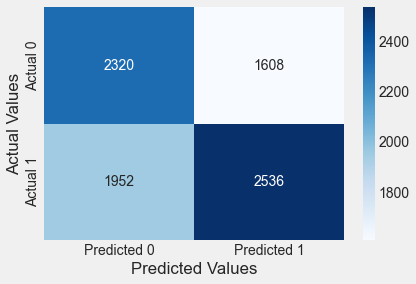

In [275]:
confusion_matrix_data(data,data.edibility,model,0.5)